In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy as sy

from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint
from scipy.special import lpmn
from sympy import assoc_legendre, diff
from sympy.abc import x, m, n
from scipy.special import jv
from scipy.special import jnyn_zeros

In [2]:
R_earth = 6400000
R_m = 16 * R_earth
b = 5 * R_earth
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10

In [ ]:
theta = np.linspace(0, np.pi, num=10)
phi = np.linspace(0, 2*np.pi, num=10)
r = np.linspace(1, 5, num=10)

th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

mat = np.concatenate((rr, th, ph), axis=-1)
mat = mat.reshape(-1, 3)

Функция conf_B_dip задает магнитное поле в сферических координатах, а sphere_to_decart очевидно переводит из сферических координат в декартовы точку в пространстве и вектор магнитного поля.

Тут же добавим поле от токов Чапмана-Ферраро. Тут их несколько, так как первый написан в диссертации Ани Стэйдельманн, но он не выполняет её же граничное условие $B_r^{dip}$ = -$B_r^{cfi}$, поэтому я игрался со знаками, и результаты, связанные с этим, будут ниже.

$$B_r = 2\Big(\frac{R_{earth}}{R_m}\Big)^3(g_{10}cos(\theta) + (g_{11}cos(\phi) + h_{11}sin(\phi))sin(\theta))$$
$$B_{\theta} = -2\Big(\frac{R_{earth}}{R_m}\Big)^3(g_{10}sin(\theta) - (g_{11}cos(\phi) + h_{11}sin(\phi))cos(\theta))$$
$$B_{\phi} = 2\Big(\frac{R_{earth}}{R_m}\Big)^3(-g_{11}sin(\phi)+h_{11}cos(\phi))$$

In [3]:
def conf_B_dip(point):
    r, theta, phi = point
    B_r = 2*((R_earth / r)**3)*(g_10*cos(theta) + (g_11*cos(phi) + h_11*sin(phi))*sin(theta))
    B_theta = -((R_earth / r)**3)*(-g_10*sin(theta) + (g_11*cos(phi) + h_11*sin(phi))*cos(theta))
    B_phi = -((R_earth / r)**3)*(-g_11*sin(phi)+h_11*cos(phi))
    return np.array([B_r, B_theta, B_phi])

def sphere_to_decart_dip(point, B):
    r, theta, phi = point
    C = np.array([[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)],
                  [cos(theta)*cos(phi), cos(theta)*sin(phi), -sin(theta)],
                  [-sin(phi), cos(phi), 0]])
    B_xyz = B @ C
    point_xyz = np.array([r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)])
    return B_xyz, point_xyz

def decart_to_sphere(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z /  r)
    phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
    return np.array([r, theta, phi])

def GSE_to_Ssphere(point):
    r, theta, phi = point
    x, y, z = r*cos(theta), r*sin(theta)*sin(phi), -(r*sin(theta)*cos(phi) + b)
    return decart_to_sphere(x, y, z)
    

Чтобы получить линии магнитного поля я решил, что можно брать какие-то точки на поверхности Земли и от них двигаться по полю. Алгоритм для одной начальной точки останавливался, когда она возвращалась обратно на поверхность Земли или уходила слишком далеко (на 10 радиусов Земли). Шаг был взят большой, а именно $10^{11}$, так как поле слабое (порядка 50 мкТл), а радиус у Земли большой.

In [ ]:
theta = np.linspace(0, np.pi, num=9)
phi = np.linspace(0, 2*np.pi, num=10)
r = np.linspace(R_earth, R_earth, num=1)


th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

start_points = np.concatenate((rr, th, ph), axis=-1)
start_points = start_points.reshape(-1, 3)


def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

data = []
(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(0, 0, 0, R_earth)
data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))


for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    while r >= R_earth and r <= R_earth*10:
        
        B = conf_B_dip(point)
        B_xyz, point_xyz = sphere_to_decart(point, B)

        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        
        
        point_xyz = point_xyz + step*B_xyz*1e11
        
        
        point = decart_to_sphere(*point_xyz)
        
        
        r = np.sqrt(np.sum(point_xyz**2))
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=X, y=Y, z=Z,
                             marker=dict(
                                         size=0.1,
                                         color='blue',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )
    

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.for_each_annotation(lambda a: a.update(text=""))
# fig.update_layout(showlegend=False)
fig.show()

3D изображение сверху:
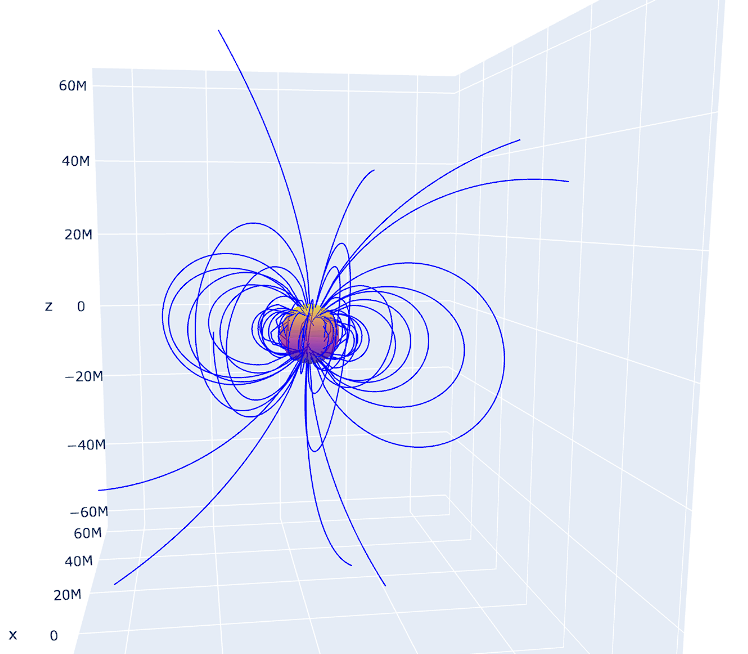

Дальше будем уже решать уравнение движения невзаимодействующих заряженных частиц в магнитном поле Земли. Частицы невзаимодейсвующие, так как мы будем запускать протоны с энергией 1 МэВ, на которые магнитное поле Земли будет действовать в несколько порядков с большей силой, чем они друг на друга (частиц немного, поэтому сравнивалась сила электростатического отталкивания на расстоянии один метр друг от друга).

Уравнение движения 

$$ma = q[v,B(x, y, z)]$$ 

перепишем в виде обычного дифференциального уравнения:

$$\vec{y}' = f(t, \vec{y})$$

Тогда у нас получится следующая система уравнений:
$$
\begin{cases}
\frac{dy_1}{dt} = y_2 \\
\frac{dy_2}{dt} = \frac{q}{m}(y_4 B_z(y1, y3, y5) - y_6 B_y(y_1, y_3, y_5)) \\
\frac{dy_3}{dt} = y_4 \\
\frac{dy_4}{dt} = \frac{q}{m}(y_6 B_x(y1, y3, y5) - y_2 B_z(y_1, y_3, y_5)) \\
\frac{dy_5}{dt} = y_6 \\
\frac{dy_6}{dt} = \frac{q}{m}(y_2 B_y(y1, y3, y5) - y_4 B_x(y_1, y_3, y_5))
\end{cases}
$$

In [ ]:
def pend(y, t, q, m):
    y1, y2, y3, y4, y5, y6 = y
    point = decart_to_sphere(y1, y3, y5)
    B = conf_B_dip(point)
    B_xyz, point_xyz = sphere_to_decart(point, B)
    f = [y2, q/m*(y4*B_xyz[2] - y6*B_xyz[1]), y4, q/m*(y6*B_xyz[0] - y2*B_xyz[2]), y6, q/m*(y2*B_xyz[1] - y4*B_xyz[0])]
    return f

In [ ]:
rs = [1.5 , 2, 2.5, 3, 3.5, 4]
names = [r'$1.5\sqrt{3}R$'
         r'$2\sqrt{3}R$',
         r'$2.5\sqrt{3}R$',
         r'$3\sqrt{3}R$',
         r'$3.5\sqrt{3}R$']

colors = ['#e377c2',
          'red',
          'orange',
          'purple',
          'black'
          ]

signs = [[1, 1, 1],
         [-1, -1, -1],
         [1, -1, -1],
         [-1, 1, -1],
         [1, -1, 1]]


for r, name, color, sign in zip(rs, names, colors, signs):
    # x, v_x, y, v_y, z, v_z
    y0 = [sign[0] * r * R_earth, 1.38e7 / np.sqrt(3),
          sign[1] * r * R_earth, 1.38e7 / np.sqrt(3),
          sign[2] * r * R_earth, 1.38e7 / np.sqrt(3)]
    
    t = np.linspace(0, 150, 10000)

    sol = odeint(pend, y0, t, args=(q, m))

    X = sol[:, 0]
    Y = sol[:, 2]
    Z = sol[:, 4]

    data.append(go.Scatter3d(x=X, y=Y, z=Z,
                             marker=dict(
                                         size=0.1,
                                         color=color,                # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             name = name
                            )
               )


In [ ]:
fig = go.Figure(data=data)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    legend=dict(x=0.9)
)

fig.show()

Если 3D график сверху не отображается, то вот что на нем было

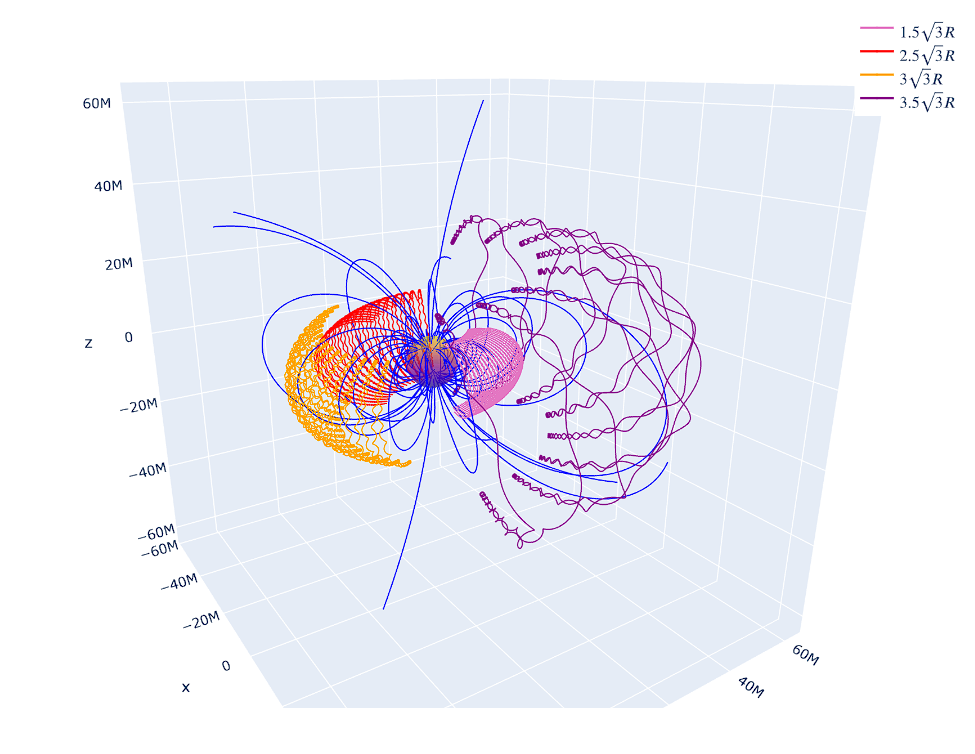

Из курса "физика плазмы" нам рассказывали, что частицы в магнитном поле земли, как в пробкотроне, заперты. Это мы и получили, но при других начальных условиях частица просто улетала на бесконечность, и такие варианты запуска частиц неинтересны, поэтому я их и не изобразил.

### Подсчет констант для поля от токов в хвостовой части


$$x_{k,i} \text{ это нули производных функций Бесселя в } \rho=R_m \rightarrow  \frac{d}{d\rho} J_k(x_{k,i} \rho / R_m)|_{\rho=R_m} = 0$$
$$\text{Для } x_{0,i} \text{ уравнение } J_1(x_{0,i}) = 0$$
$$\text{Очевидно, что для } x_{0,0} \text{ нужен первый не нулевой корень уравнения выше.}$$

$$\text{Для } x_{1,i} \text{ уравнение } J_0(x_{1,i}) = J_2(x_{1,i})$$
$$\text{Очевидно, что для } x_{1,0} \text{ нужен первый не нулевой корень уравнения выше.}$$


Мы с Егором в итоге нашли данные о первых 10000 первых экстремумов (производных равных нулю выходит) 600 функций Бесселя.

In [4]:
from scipy.special import jnyn_zeros

In [5]:
jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 100)

In [6]:
x_0 = jnp_roots

In [7]:
jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 100)

In [8]:
x_1 = jnp_roots

Отрисуем график для проверки

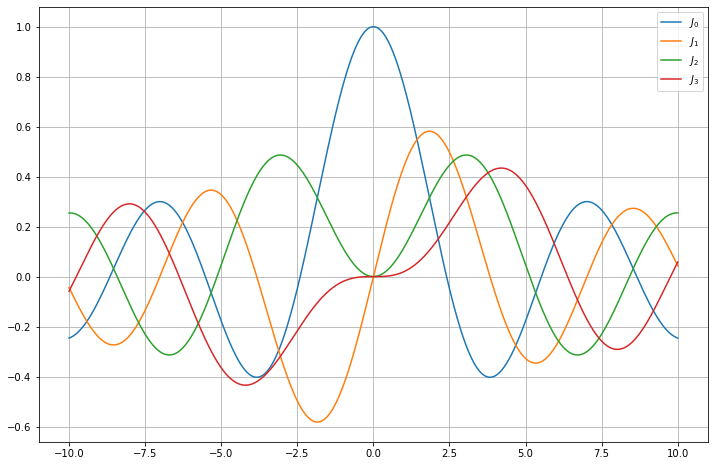

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
x = np.linspace(-10., 10., 1000)
for i in range(4):
    ax.plot(x, jv(i, x), label=f'$J_{i!r}$')
ax.legend()
plt.grid()
plt.show()

Так же для поля нужно подсчитать константы $a_{k,i}$, которые равны

$$a_{k,i} = \frac{2}{R_m^2[1 - (\frac{k}{x_{k,i}})^2][J_k(x_{k,i})]^2} \int_0^{R_m} f_k(\rho)J_k(x_{k,i} \rho / R_m)\rho d\rho$$

Так как нам нужно будет только $a_{0,0}$ и $a_{1,0}$, то тогда можно записать только как выглядят $f_0$ и $f_1$

$$f_0(\rho) = -\frac{b}{(b^2 + \rho^2)^{\frac{3}{2}}} - \frac{1}{b^2} \sum_{n=1}^{\infty} (n+1) \big(-\frac{b}{R_m}\big)^{n+1} \big(\frac{\rho}{R_m}\big)^n P_n^0(0)$$

$$f_1(\rho) = \frac{\rho}{(b^2 + \rho^2)^{\frac{3}{2}}} + \frac{1}{b^2} \sum_{n=1}^{\infty} \frac{(n+1)}{n} \big(-\frac{b}{R_m}\big)^{n+1} \big(\frac{\rho}{R_m}\big)^n P_n^1(0)$$

In [10]:
from scipy.integrate import quad
from scipy.special import lpmv
N = 100

def f0(x):
    S = -b / (b**2 + x**2)**(3/2)
    for n in range(N):
        S += -1/b**2 * (n+1)*(-b / R_m)**(n+1) * (x / R_m)**n * lpmv(0, n, 0)
    return S

def f1(x):
    S = x / (b**2 + x**2)**(3/2)
    for n in range(1, N + 1):
        S += 1/b**2 * (n+1) / n * (-b / R_m)**(n+1) * (x / R_m)**n * (-lpmv(1, n, 0))
    return S

def func(x, x_nn, v):
    if v == 0:
        return x*jv(0, x_nn * x / R_m)*f0(x)
    else:
        return x*jv(1, x_nn * x / R_m)*f1(x)


In [11]:
a_0 = [2 / (R_m**2 * jv(0, x_0[n])**2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in range(100)]
a_1 = [2 / (R_m**2 * jv(1, x_1[n])**2 * (1 - (1 / x_1[n])**2) ) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for n in range(100)]

In [12]:
#Базовая конфигурация поля диполя, которой мы и пользовались
def conf_B_dip(point):
    r, theta, phi = point
    B_r = 2*((R_earth / r)**3)*(g_10*cos(theta) + (g_11*cos(phi) + h_11*sin(phi))*sin(theta))
    B_theta = -((R_earth / r)**3)*(-g_10*sin(theta) + (g_11*cos(phi) + h_11*sin(phi))*cos(theta))
    B_phi = -((R_earth / r)**3)*(-g_11*sin(phi)+h_11*cos(phi))
    return np.array([B_r, B_theta, B_phi])

#Конфигурация поля диполя через декартовы координаты в GSE-системе
def conf_B_dip_xyz_GSE(point):
    r, theta, phi = point
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    
    B_x = -(R_earth / r)**3 * g_11 + 3*R_earth**3 / r**5 * x * (g_11*x + y*h_11 + z*g_10)
    B_y = -(R_earth / r)**3 * h_11 + 3*R_earth**3 / r**5 * y * (g_11*x + y*h_11 + z*g_10)
    B_z = -(R_earth / r)**3 * g_10 + 3*R_earth**3 / r**5 * z * (g_11*x + y*h_11 + z*g_10)
    return np.array([B_x, B_y, B_z])

#Конфигурация поля диполя через декартовы координаты в M-системе 
def conf_B_dip_xyz_M(point):
    r_M, theta_M, phi_M = point
    x_M, y_M, z_M = r_M*sin(theta_M)*cos(phi_M), r_M*sin(theta_M)*sin(phi_M), r_M*cos(theta_M)
    
    r = np.sqrt((z_M + b)**2 + y_M**2 + x_M**2)
    
    B_x = -(R_earth / r)**3 * g_10 + 3*R_earth**3 / r**5 * x_M * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
    B_y = -(R_earth / r)**3 * h_11 + 3*R_earth**3 / r**5 * y_M * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
    B_z = (R_earth / r)**3 * g_11 + 3*R_earth**3 / r**5 * (z_M+b) * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
    return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

def decart_to_sphere(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z /  r)
    phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
    return np.array([r, theta, phi])

Тут я решил работать не в GSE-системе координат, а в M-системе, так как это бы упрощало жизнь с формулами, но единственное, что точки нужно задавать на поверхности Земли тяжелее.

In [14]:
maxiter = 10000
theta = np.linspace(0, np.pi, num=10)
phi = np.linspace(0, 2*np.pi, num=10)
r = np.linspace(R_earth, R_earth, num=1)


th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

start_points = np.concatenate((rr, th, ph), axis=-1)
start_points = start_points.reshape(-1, 3)


def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

data = []
(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))


for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    i = 0
    
    r, theta, phi = point
    
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x_M, y_M, z_M = z, y, -(x+b)
    point = decart_to_sphere(x_M, y_M, z_M)

    
    while r >= R_earth and r <= 5*R_m and i < maxiter:
        
        B_xyz, point_xyz = conf_B_dip_xyz_M(point)
        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e5
        
        
        point = decart_to_sphere(*point_xyz)
        
        x, y, z = point_xyz
        
        r = np.sqrt(x**2 + y**2 + (z + b)**2)
        i += 1
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                             marker=dict(
                                         size=0.1,
                                         color='blue',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.for_each_annotation(lambda a: a.update(text=""))
# fig.update_layout(showlegend=False)
fig.show()

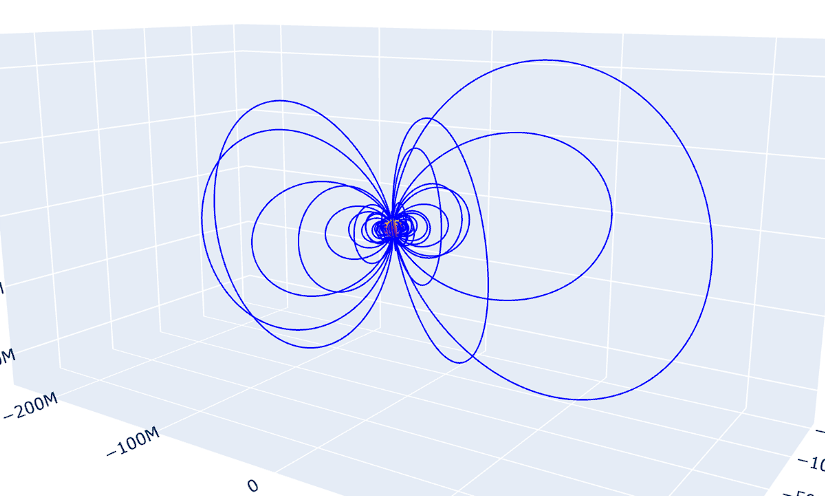

В общем для поля от токов Чапмана-Ферраро, нам нужно выражение 

$$\frac{P_n^1(cos(\theta))}{sin(theta)}$$

А $P_n^1(cos(\theta))$ вообще говоря в себе содержит модуль синуса, так что при углах 0 и $\pi$ у нас могли возникнуть проблемы, поэтому я просто решил 10 лежандров, их производные и отношения с синусом выписать вручную.

Так же я решил всё выписать ручками, потому что оказывается присоединенный полином Лежандра в scipy и wolfram matematica по-другому определен.

Вот как он определен в Scipy и Wolfram Matematica:
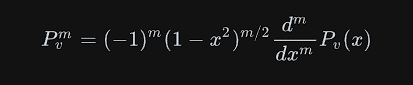

А вот как в статье:
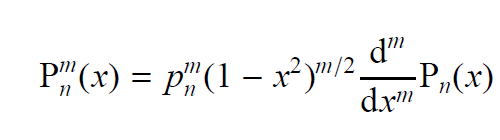

$p_n^m$ берется за единицу у Voigt(1981), так что различие только в знаке идет, но такое существенное....

In [13]:
def legs(theta):
    
    legs_0n = [cos(theta), 1/2*(3*cos(theta)**2-1),
               1/2*(5*cos(theta)**3-3*cos(theta)), 1/8*(35*cos(theta)**4-30*cos(theta)**2+3),
              1/8*(63*cos(theta)**5-70*cos(theta)**3+15*cos(theta)), 1/16*(231*cos(theta)**6-315*cos(theta)**4+105*cos(theta)**2-5),
              1/16*(429*cos(theta)**7-693*cos(theta)**5+315*cos(theta)**3-35*cos(theta)), 1/128*(6435*cos(theta)**8 - 12012*cos(theta)**6 + 6930*cos(theta)**4 - 1260*cos(theta)**2 + 35),
              1/128*(12155*cos(theta)**9 - 25740*cos(theta)**7 + 18018*cos(theta)**5 - 4620*cos(theta)**3 + 315*cos(theta)),
              1/256*(46189*cos(theta)**10 - 109395*cos(theta)**8 + 90090*cos(theta)**6 - 30030*cos(theta)**4 + 3465*cos(theta)**2 - 63)]
    
    legs_1n = [np.abs(sin(theta)), 3*cos(theta)*np.abs(sin(theta)),
               3/2*np.abs(sin(theta))*(5*cos(theta)**2-1), 5/2*np.abs(sin(theta))*(7*cos(theta)**3-3*cos(theta)),
              15/8*np.abs(sin(theta))*(21*cos(theta)**4-14*cos(theta)**2+1), 21/8*np.abs(sin(theta))*(33*cos(theta)**5-30*cos(theta)**3+5*cos(theta)),
              7/16*np.abs(sin(theta))*(429*cos(theta)**6-495*cos(theta)**4+135*cos(theta)**2-5), 9/16*np.abs(sin(theta))*(715*cos(theta)**7-1001*cos(theta)**5+385*cos(theta)**3-35*cos(theta)),
              45/128*np.abs(sin(theta))*(2431*cos(theta)**8 - 4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
              55/128*np.abs(sin(theta))*(4199*cos(theta)**9 - 7956*cos(theta)**7 + 4914*cos(theta)**5 - 1092*cos(theta)**3 + 63*cos(theta))]
    
    divlegs_0n = [-sin(theta), -3*sin(theta)*cos(theta),
                  -3/2*sin(theta)*(5*cos(theta)**2-1), -5/2*sin(theta)*cos(theta)*(7*cos(theta)**2-3),
                 -15/8*sin(theta)*(21*cos(theta)**4 - 14*cos(theta)**2 + 1), -21/8*sin(theta)*cos(theta)*(33*cos(theta)**4 - 30*cos(theta)**2 + 5),
                 -7/16*sin(theta)*(429*cos(theta)**6 - 495*cos(theta)**4 + 135*cos(theta)**2 - 5), -9/16*sin(theta)*cos(theta)*(715*cos(theta)**6 - 1001*cos(theta)**4 + 385*cos(theta)**2 - 35),
                 -45/128*sin(theta)*(2431*cos(theta)**8-4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
                 -55/128*sin(theta)*cos(theta)*(4199*cos(theta)**8 - 7956*cos(theta)**6 + 4914*cos(theta)**4 - 1092*cos(theta)**2 + 63)]
    
    divlegs_1n = [cos(theta)*np.sign(sin(theta)), -3*np.sign(sin(theta))*(1-2*cos(theta)**2),
                  -3/2*np.sign(sin(theta))*cos(theta)*(11-15*cos(theta)**2), 5/2*np.sign(sin(theta))*(28*cos(theta)**4 - 27*cos(theta)**2 + 3),
                 15/8*np.sign(sin(theta))*cos(theta)*(105*cos(theta)**4 - 126*cos(theta)**2 + 29), 21/8*np.sign(sin(theta))*(198*cos(theta)**6 - 285*cos(theta)**4 + 100*cos(theta)**2 - 5),
                 7/16*np.sign(sin(theta))*cos(theta)*(3003*cos(theta)**6 - 5049*cos(theta)**4 + 2385*cos(theta)**2 - 275),
                 9/16*np.sign(sin(theta))*(5720*cos(theta)**8 - 11011*cos(theta)**6 + 6545*cos(theta)**4 - 1225*cos(theta)**2 + 35),
                 45/128*np.sign(sin(theta))*cos(theta)*(21879*cos(theta)**8 - 47476*cos(theta)**6+34034*cos(theta)**4-8932*cos(theta)**2+623),
                 55/128*np.sign(sin(theta))*(41990*cos(theta)**10-101439*cos(theta)**8+85176*cos(theta)**6-28938*cos(theta)**4+3402*cos(theta)**2 - 63)]
    
    legs_1n_div_sin = [np.sign(sin(theta)), 3*cos(theta)*np.sign(sin(theta)),
                       3/2*np.sign(sin(theta))*(5*cos(theta)**2-1), 5/2*np.sign(sin(theta))*(7*cos(theta)**3-3*cos(theta)),
                      15/8*np.sign(sin(theta))*(21*cos(theta)**4-14*cos(theta)**2+1), 21/8*np.sign(sin(theta))*(33*cos(theta)**5-30*cos(theta)**3+5*cos(theta)),
                      7/16*np.sign(sin(theta))*(429*cos(theta)**6-495*cos(theta)**4+135*cos(theta)**2-5), 9/16*np.sign(sin(theta))*(715*cos(theta)**7-1001*cos(theta)**5+385*cos(theta)**3-35*cos(theta)),
                      45/128*np.sign(sin(theta))*(2431*cos(theta)**8 - 4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
                      55/128*np.sign(sin(theta))*(4199*cos(theta)**9 - 7956*cos(theta)**7 + 4914*cos(theta)**5 - 1092*cos(theta)**3 + 63*cos(theta))]
    
    
    return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin

In [14]:
def conf_B_cfi_N(point, N=1):
    r, theta, phi = point
    B_r = 0
    B_theta = 0
    B_phi = 0
    
    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    
    
    for n in range(1, N + 1):
        leg_0n = legs_0n[n-1]
        leg_1n = legs_1n[n-1]
        
        divleg_0n = divlegs_0n[n-1]
        divleg_1n = divlegs_1n[n-1]
        
        leg_1n_div_sin = legs_1n_div_sin[n-1]
        
        B_r += mu_0 / (4*np.pi * b**3) * (n+1) * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
               -n*m_x*leg_0n + (m_z*cos(phi) + m_y*sin(phi)) * leg_1n
            )
        
        B_theta +=  mu_0 / (4*np.pi * b**3) * (n+1) / n * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
                    -n*m_x*divleg_0n + (m_z*cos(phi) + m_y*sin(phi)) * divleg_1n
        )
        
        B_phi += mu_0 / (4*np.pi * b**3) * (n+1) / n * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
                    (-m_z*sin(phi) + m_y*cos(phi)) * leg_1n_div_sin
        )

    return np.array([B_r, B_theta, B_phi])


In [15]:
def conf_B_cfi(point):
    r, theta, phi = point
    B_r = 2*((R_earth / R_m)**3)*(g_11*cos(theta) - (g_10*cos(phi) + h_11*sin(phi))*np.abs(sin(theta)))
    B_theta = -2*((R_earth / R_m)**3)*(g_11*sin(theta) + (g_10*cos(phi) + h_11*sin(phi))*cos(theta)*np.sign(sin(theta)))
    B_phi = -2*((R_earth / R_m)**3)*(-g_10*sin(phi)+h_11*cos(phi))*np.sign(sin(theta))
    return np.array([B_r, B_theta, B_phi])

def sphere_to_decart(point, B):
    r, theta, phi = point
    C = np.array([[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)],
                  [cos(theta)*cos(phi), cos(theta)*sin(phi), -sin(theta)],
                  [-sin(phi), cos(phi), 0]])
    B_xyz = B @ C
    point_xyz = np.array([r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)])
    return B_xyz, point_xyz

def decart_to_sphere(x, y, z, eps=1e-8):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z /  r)
    phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
    return np.array([r, theta, phi])

In [19]:
maxiter = 10000
C_i = 0.1


theta = np.linspace(0, np.pi, num=10)
phi = np.linspace(0, 2*np.pi, num=20)
r = np.linspace(R_earth, R_earth, num=1)


th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

start_points = np.concatenate((rr, th, ph), axis=-1)
start_points = start_points.reshape(-1, 3)


def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

data = []
(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))


for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    i = 0
    
    r, theta, phi = point
    
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x_M, y_M, z_M = z, y, -(x+b)
    point = decart_to_sphere(x_M, y_M, z_M)

    
    while r >= R_earth and r <= 5*R_m and i < maxiter:
        
        B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)
        
        B_cfi = conf_B_cfi_N(point, N=10)
        B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)
        
        point_xyz = point_dip_xyz
        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz
        point_xyz = point_dip_xyz
        
        point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e5
        
        
        point = decart_to_sphere(*point_xyz)
        
        x, y, z = point_xyz
        
        r = np.sqrt(x**2 + y**2 + (z + b)**2)
        i += 1
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                             marker=dict(
                                         size=0.1,
                                         color='blue',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )

In [20]:
for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    i = 0
    
    r, theta, phi = point
    
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x_M, y_M, z_M = z, y, -(x+b)
    point = decart_to_sphere(x_M, y_M, z_M)

    
    while r >= R_earth and r <= 5*R_m and i < maxiter:
        
        B_xyz, point_xyz = conf_B_dip_xyz_M(point)
        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e6
        
        
        point = decart_to_sphere(*point_xyz)
        
        x, y, z = point_xyz
        
        r = np.sqrt(x**2 + y**2 + (z + b)**2)
        i += 1
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                             marker=dict(
                                         size=0.1,
                                         color='orange',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.for_each_annotation(lambda a: a.update(text=""))
# fig.update_layout(showlegend=False)
fig.show()

Снизу приведен синим результат дипольного поля вместе с полем от токов Чапмана-Ферраро и оранжевым просто диполя.

На первом изображении использование только первого члена в формуле (3.25).

На втором первые 10 членов суммы формулы (3.25)

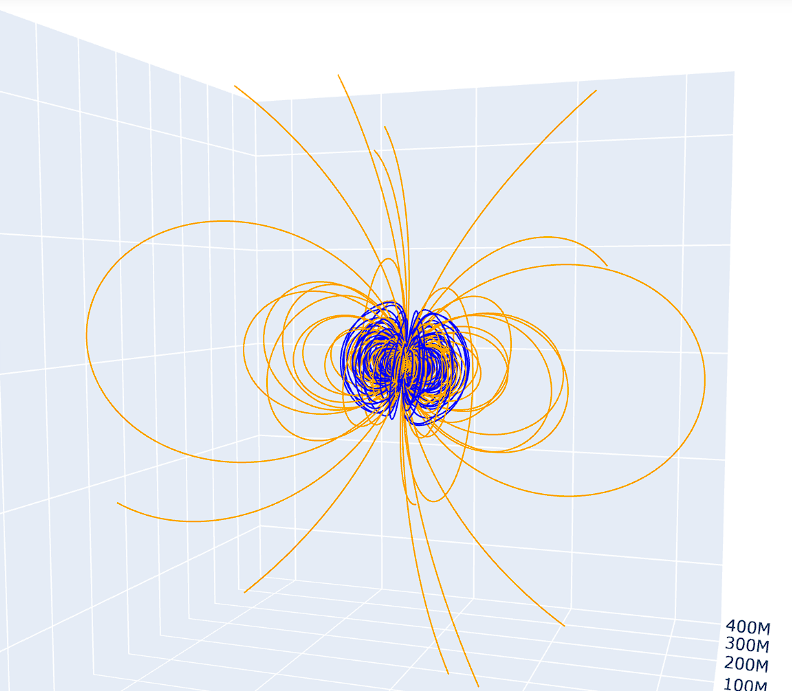

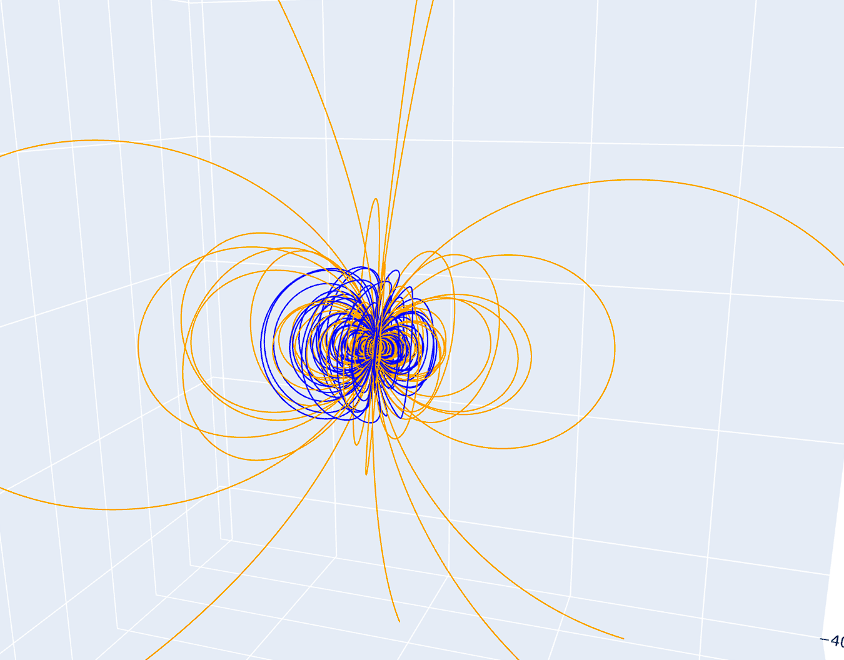

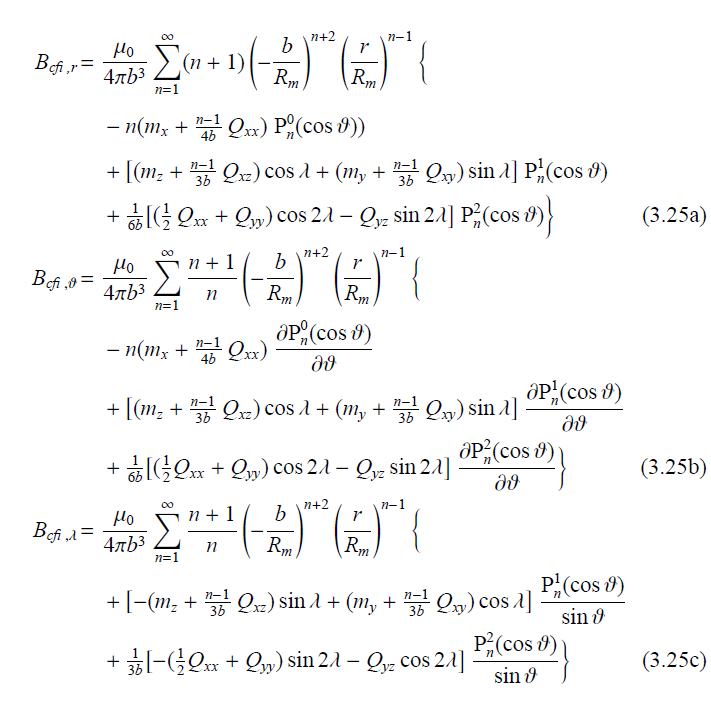

In [16]:
def spher_to_cyl(point):
    r, theta, phi = point
    
    rho = r*sin(theta)
    phi = phi
    z = r*cos(theta)
    
    return rho, phi, z

def conf_B_tail(point, lambd, N=10):
    rho, phi, z = spher_to_cyl(point)
    
    B_rho = 0
    B_phi = 0
    B_z = 0
    
    for n in range(N):
        
        B_rho += mu_0/(4*np.pi)*(x_0[n] / R_m * m_x * a_0[n]*jv(1, x_0[n] * rho / R_m)*np.exp(-x_0[n]*z/R_m)
                                    + 0.5*x_1[n]/R_m*a_1[n]*m_z*cos(phi)*(jv(2, x_1[n] * rho / R_m) - jv(0, x_1[n] * rho / R_m))*np.exp(-x_1[n]*z/R_m)
                                    + 0.5*x_1[n]/R_m*a_1[n]*m_y*sin(phi)*(jv(2, x_1[n] * rho / R_m) - jv(0, x_1[n] * rho / R_m))*np.exp(-x_1[n]*z/R_m)
                                )

        B_phi += mu_0/(4*np.pi)*(1/rho*a_1[n]*m_z*sin(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-x_1[n]*z/R_m)
                                     - 1/rho*a_1[n]*m_y*cos(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-x_1[n]*z/R_m)
                                )

        B_z += mu_0/(4*np.pi)*(x_0[n] / R_m * m_x * a_0[n]*jv(0, x_0[n] * rho / R_m)*np.exp(-x_0[n]*z/R_m)
                                   + x_1[n]/R_m*a_1[n]*m_z*cos(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-x_1[n]*z/R_m)
                                   + x_1[n]/R_m*a_1[n]*m_y*sin(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-x_1[n]*z/R_m)
                              )
        
        B_rho += lambd*mu_0/(4*np.pi)*(x_0[n] / R_m * m_x * a_0[n]*jv(1, x_0[n] * rho / R_m)*np.exp(-lambd*x_0[n]*z/R_m)
                                    + 0.5*x_1[n]/R_m*a_1[n]*m_z*cos(phi)*(jv(2, x_1[n] * rho / R_m) - jv(0, x_1[n] * rho / R_m))*np.exp(-lambd*x_1[n]*z/R_m)
                                    + 0.5*x_1[n]/R_m*a_1[n]*m_y*sin(phi)*(jv(2, x_1[n] * rho / R_m) - jv(0, x_1[n] * rho / R_m))*np.exp(-lambd*x_1[n]*z/R_m)
                                )

        B_phi += lambd*mu_0/(4*np.pi)*(1/rho*a_1[n]*m_z*sin(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-lambd*x_1[n]*z/R_m)
                                     - 1/rho*a_1[n]*m_y*cos(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-lambd*x_1[n]*z/R_m)
                                )

        B_z += mu_0/(4*np.pi)*(x_0[n] / R_m * m_x * a_0[n]*jv(0, x_0[n] * rho / R_m)*np.exp(-lambd*x_0[n]*z/R_m)
                                   + x_1[n]/R_m*a_1[n]*m_z*cos(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-lambd*x_1[n]*z/R_m)
                                   + x_1[n]/R_m*a_1[n]*m_y*sin(phi)*jv(1, x_1[n] * rho / R_m)*np.exp(-lambd*x_1[n]*z/R_m)
                              )
    
    
    
    return np.array([B_rho, B_phi, B_z])

def cyl_to_dec(point, B):
    rho, phi, z = spher_to_cyl(point)
    C = np.array([[cos(phi), -sin(phi), 0],
                  [sin(phi), cos(phi), 0],
                  [0, 0, 1]])
    B_xyz = C @ B
    point_xyz = np.array([rho*cos(phi), rho*sin(phi), z])
    return B_xyz, point_xyz

In [23]:
maxiter = 10000
C_i = 0.1
lambd = 0.15

theta = np.linspace(0, np.pi/2, num=25)
phi = np.linspace(0, 2*np.pi, num=10)
r = np.linspace(R_earth, R_earth, num=1)


th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

start_points = np.concatenate((rr, th, ph), axis=-1)
start_points = start_points.reshape(-1, 3)


def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

data = []
(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))


for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    i = 0
    
    r, theta, phi = point
    
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x_M, y_M, z_M = z, y, -(x+b)
    point = decart_to_sphere(x_M, y_M, z_M)

    
    while r >= R_earth and r <= 2*R_m and i < maxiter:
        
        B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)
        
        B_cfi = conf_B_cfi_N(point, N=10)
        B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)
        
        B_tail = conf_B_tail(point, lambd, N=10)
        B_tail_xyz, point_tail_xyz = cyl_to_dec(point, B_tail)
        
        point_xyz = point_dip_xyz
        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        #проверка в цилиндре мы или в полусфере
        if point_xyz[-1] < 0:
            B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz
        else:
            B_xyz = B_tail_xyz
        
        #Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за этого
        if (R_m - b) * 1/8 <= r <= (R_m - b) * 15/8:
            point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e5
        else:
            point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e6
        
        
        point = decart_to_sphere(*point_xyz)
        
        x, y, z = point_xyz
        
        r = np.sqrt(x**2 + y**2 + (z + b)**2)
        i += 1
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                             marker=dict(
                                         size=0.1,
                                         color='blue',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.for_each_annotation(lambda a: a.update(text=""))
# fig.update_layout(showlegend=False)
fig.show()

Вот он результат наконец-то получился

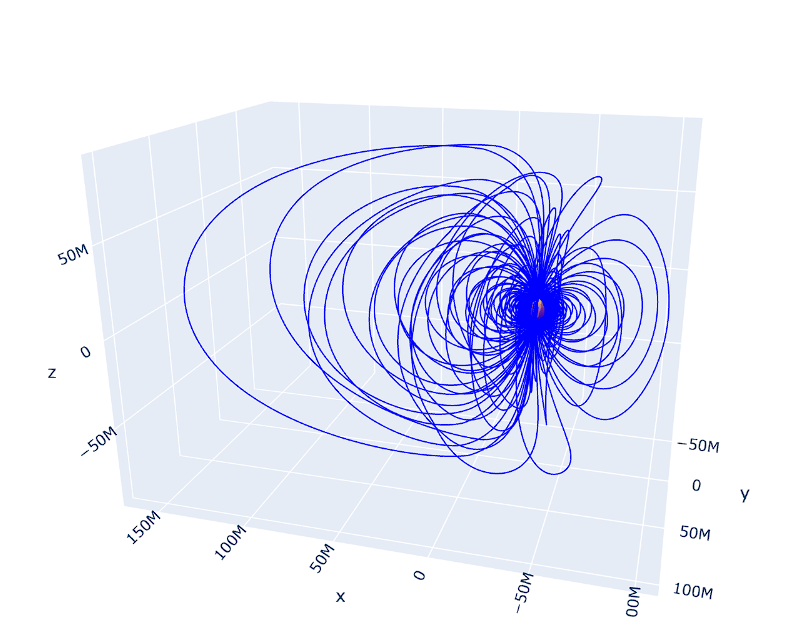

Снизу изображение с большими начальными точками, у которого есть "рожки", но они связаны с тем, что шаг $10^6$ достаточно большой, из-за чего мы перелетаем границу полусферы и улетаем на бесконечность.

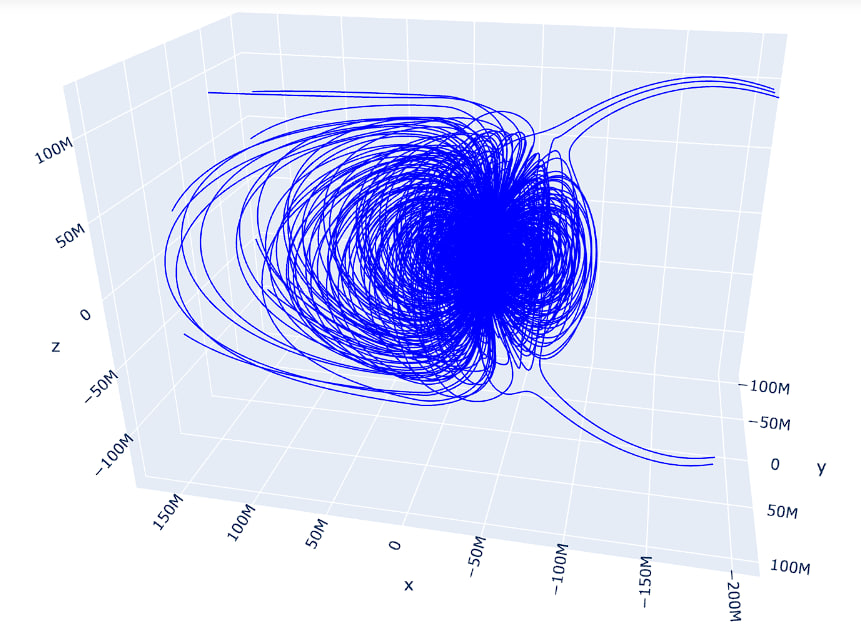

In [50]:
B_imf_xyz = np.array([5*1e-9, 0, 0])

In [51]:
def conf_B_sphere_cfa(point):
    r, theta, phi = point
    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    B_cfa_r = - (R_m / r)**3 * (B_imf_xyz[2]*legs_0n[0] + B_imf_xyz[0]*cos(phi)*legs_1n[0] + B_imf_xyz[1]*sin(phi)*legs_1n[0])
    B_cfa_theta = 0.5 * (R_m / r)**3 * (B_imf_xyz[2]*divlegs_0n[0] + B_imf_xyz[0]*cos(phi)*divlegs_1n[0] + B_imf_xyz[1]*sin(phi)*divlegs_1n[0])
    B_cfa_phi = 0.5 * (R_m / r)**3 * (-B_imf_xyz[0]*sin(phi)*legs_1n_div_sin[0] + B_imf_xyz[1]*cos(phi)*legs_1n_div_sin[0])
    return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

def conf_B_cyl_cfa(point):
    rho, phi, z = spher_to_cyl(point)
    B_cfa_rho = - (R_m / rho)**2 * (B_imf_xyz[0]*cos(phi) + B_imf_xyz[1]*sin(phi))
    B_cfa_phi = (R_m / rho)**2 * (-B_imf_xyz[0]*sin(phi) + B_imf_xyz[1]*cos(phi))
    B_cfa_z = 0
    return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])


In [52]:
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15

theta = np.linspace(0, np.pi, num=25)
phi = np.linspace(0, 2*np.pi, num=10)
r = np.linspace(R_earth, R_earth, num=1)


th, ph, rr = np.meshgrid(theta, phi, r)

th = np.expand_dims(th, axis=-1)
ph = np.expand_dims(ph, axis=-1)
rr = np.expand_dims(rr, axis=-1)

start_points = np.concatenate((rr, th, ph), axis=-1)
start_points = start_points.reshape(-1, 3)


def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

data = []
(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))


for point in start_points:
    r = point[0]
    step = -1 if point[1] < np.pi/2 else 1
    X = []
    Y = []
    Z = []
    i = 0
    
    r, theta, phi = point
    
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x_M, y_M, z_M = z, y, -(x+b)
    point = decart_to_sphere(x_M, y_M, z_M)

    
    while r >= R_earth and r <= 2*R_m and i < maxiter:
        
        B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)
        
        B_cfi = conf_B_cfi_N(point, N=10)
        B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)
        
        B_cfa = conf_B_sphere_cfa(point)
        B_cfa_xyz, point_cfa_xyz = sphere_to_decart(point, B_cfa)
        
        B_tail = conf_B_tail(point, lambd, N=10)
        B_tail_xyz, point_tail_xyz = cyl_to_dec(point, B_tail)
        
        B_cfa_cyl = conf_B_cyl_cfa(point)
        B_cfa_cyl_xyz, point_cfa_cyl_xyz = cyl_to_dec(point, B_cfa_cyl)
        
        point_xyz = point_dip_xyz
        
        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]
        
        #проверка в цилиндре мы или в полусфере
        if point_xyz[-1] < 0 and point[0] < R_m:
            B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a*B_imf_xyz
        elif point_xyz[-1] > 0 and point[0]*sin(point[1]) < R_m:
            B_xyz = B_tail_xyz + C_a*B_imf_xyz
        elif point_xyz[-1] < 0 and point[0] >= R_m:
            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
        else:
            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz
        
        #Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за этого
        if (R_m - b) * 1/8 <= r <= (R_m - b) * 15/8:
            point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e5
        else:
            point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e6
        
        
        point = decart_to_sphere(*point_xyz)
        
        x, y, z = point_xyz
        
        r = np.sqrt(x**2 + y**2 + (z + b)**2)
        i += 1
    
    X += [point_xyz[0]]
    Y += [point_xyz[1]]
    Z += [point_xyz[2]]
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                             marker=dict(
                                         size=0.1,
                                         color='blue',      # set color to an array/list of desired values
                                         colorscale=None,   # choose a colorscale
                                         opacity=0.8
                                        ),
                             showlegend=False
                            )
               )

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.for_each_annotation(lambda a: a.update(text=""))
# fig.update_layout(showlegend=False)
fig.show()

B_imf = (0, 0, -5) нТл
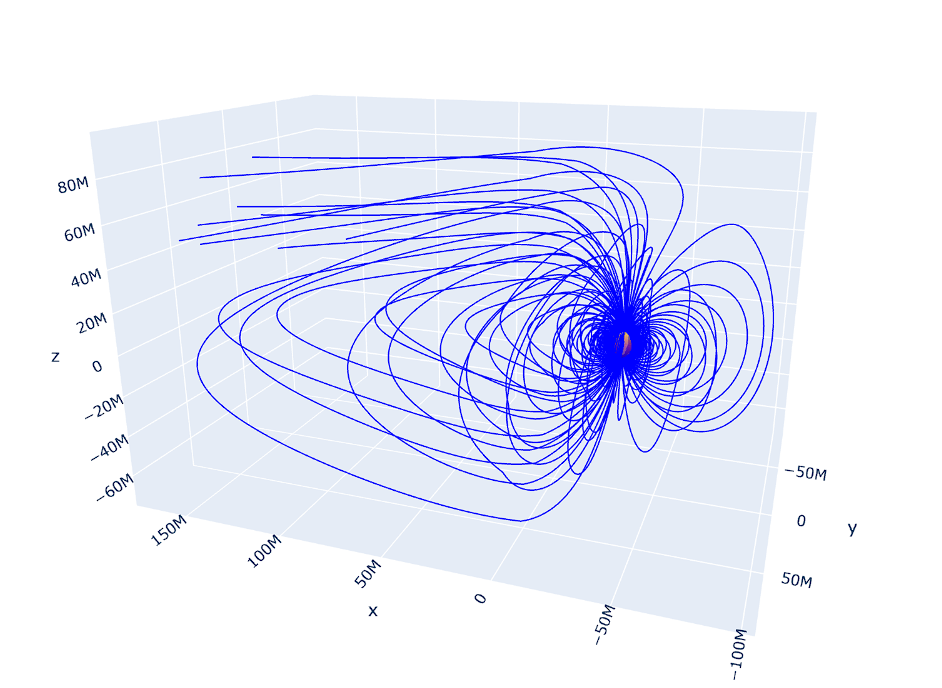

B_imf = (0, 0, 5) нТл
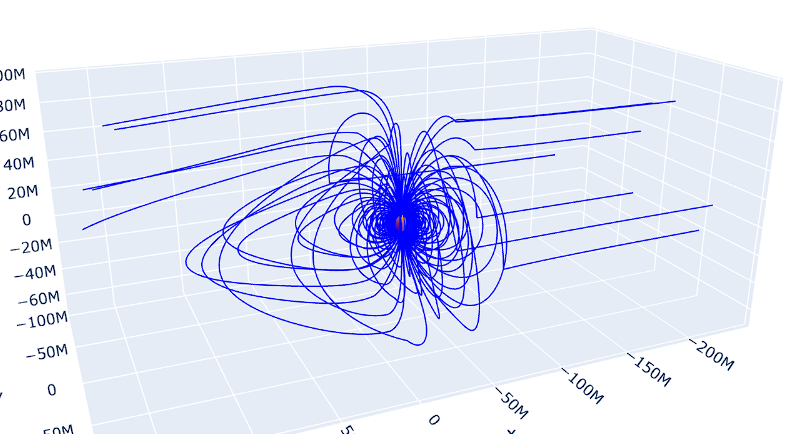
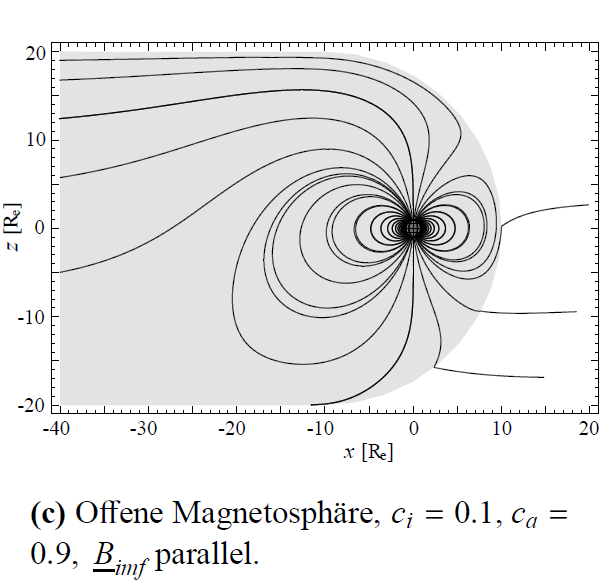

B_imf = (5, 0, 0) нТл
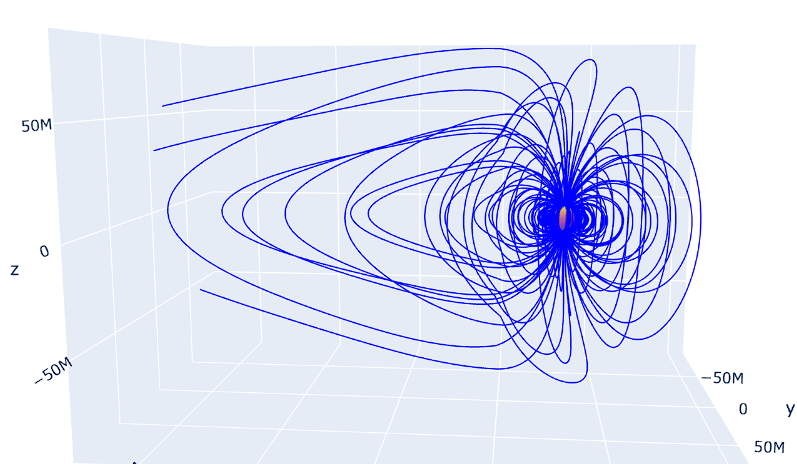

B_imf = (-5, 0, 0) нТл
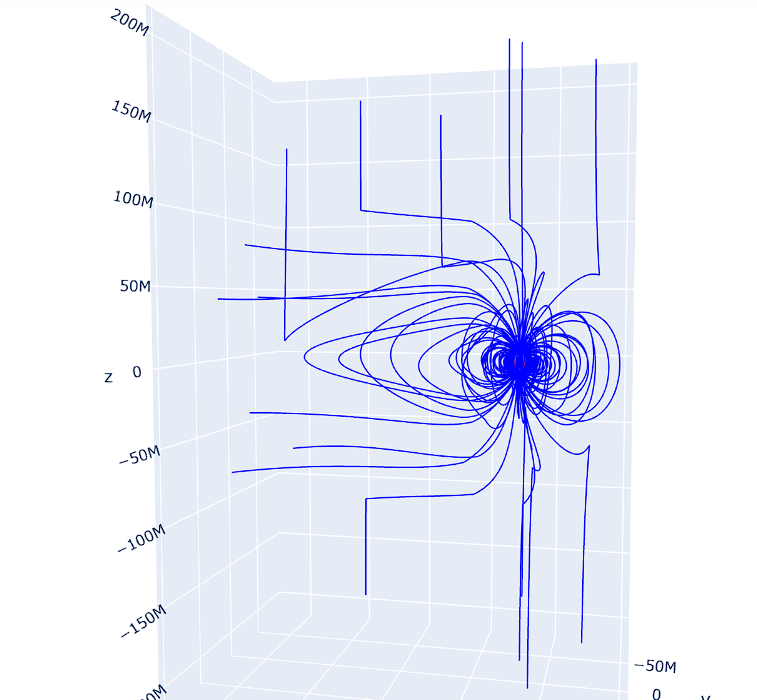
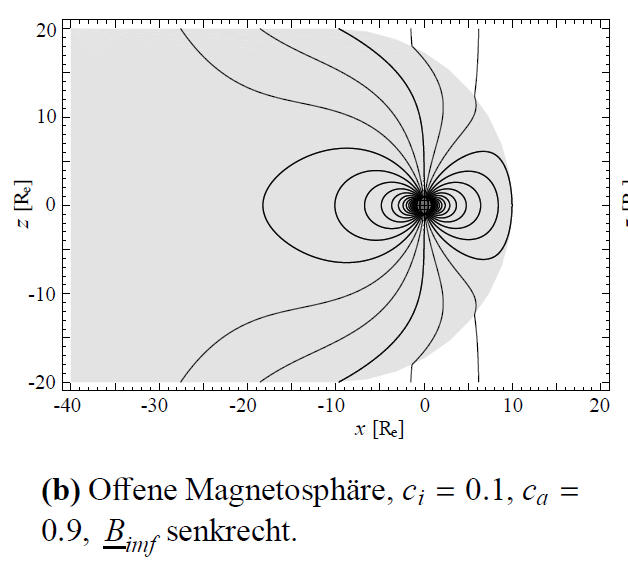

Здесь была проверка на гран условия

In [ ]:
C_i = 0.9
C_a = 0.1
lambd = 1
maxiter = 1000

z = np.linspace(1e-8, 1e-8, num=1)
phi = np.linspace(0, 2*np.pi, num=10)
rho = np.linspace(R_m/2, R_m/2, num=1)


rh, ph, zz = np.meshgrid(rho, phi, z)

rh = np.expand_dims(rh, axis=-1)
ph = np.expand_dims(ph, axis=-1)
zz = np.expand_dims(zz, axis=-1)

start_points = np.concatenate((rh, ph, zz), axis=-1)
start_points = start_points.reshape(-1, 3)


for point_cyl in start_points:
    
    rho, phi, z = point_cyl
    
    r = np.sqrt(z**2 + rho**2)
    phi = phi
    theta = np.arctan(rho / z) if z > 0 else np.arctan(rho / z) + np.pi
    point = np.array([r, theta, phi])
        
    B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)
        
    B_cfi = conf_B_cfi_5(point, N=10)
    B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)
    
    B_tail = conf_B_tail(point, lambd, N=10)
    B_tail_xyz, point_tail_xyz = cyl_to_dec(point, B_tail)

    point_xyz = point_dip_xyz



    

    print(f'B_dip + B_cfi: {B_dip_xyz + B_cfi_xyz}')
    print(f'B_tail: {B_tail_xyz*2}')
    print('*************************')
